# **Model Evalutation**

## Objectives

* Augment training set images to ultimately improve models ability to generalise.
* **Tackle business requirement 2**: create binary classification model to predict whether a cherry leaf is healthy or contains powdery mildew.
* Validate model performance using validation dataset.
* Test model performance using test model data.
* Analyse model performance using a number of different metrics.

## Inputs

* inputs/cherry_leaves_dataset/cherry-leaves/train
* inputs/cherry_leaves_dataset/cherry-leaves/validation
* inputs/cherry_leaves_dataset/cherry-leaves/test

## Outputs

* Barplot and pie chart to visualise label and set distribution, respectively.
* cherry_leaves_model
* Metrics table, reporting on performance metrics such as precision, recall, f1-score.
* Precision-recall plot
* ROC (receiver operating characteristic) curve


# Import packages

In [1]:
import os
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn import metrics

---

# Change working directory

* We are assuming you will store the notebooks in a subfolder, therefore when running the notebook in the editor, you will need to change the working directory

We need to change the working directory from its current folder to its parent folder
* We access the current directory with os.getcwd()

In [2]:
import os
current_dir = os.getcwd()
current_dir

'/workspace/project-5/jupyter_notebooks'

We want to make the parent of the current directory the new current directory
* os.path.dirname() gets the parent directory
* os.chir() defines the new current directory

In [3]:
os.chdir(os.path.dirname(current_dir))
print("You set a new current directory")

You set a new current directory


Confirm the new current directory

In [4]:
current_dir = os.getcwd()
current_dir

'/workspace/project-5'

# Set input directories

In [5]:
data_dir = 'inputs/cherry_leaves_dataset/cherry-leaves'
train_dir = data_dir + '/train'
val_dir = data_dir + '/validation'
test_dir = data_dir + '/test'

# Set output directories

In [6]:
version_num = 'v1'
output_dir = f'outputs/{version_num}'

if os.path.exists(output_dir):
    print('Output already exists - please pick a new version number if you want to create a new output directory')
else:
    os.makedirs(output_dir)
    print(f'Output {version_num} created')

Output already exists - please pick a new version number if you want to create a new output directory


# Set labels

In [7]:
labels = os.listdir(train_dir)
print('Image labels are: ', labels)

Image labels are:  ['healthy', 'powdery_mildew']


# Set image shape

In [8]:
import joblib
image_shape = joblib.load(f'outputs/{version_num}/image_shape.pkl')
image_shape

(256, 256, 3)

---

# Plot number of images in each group

* train - healthy: 1472 images
* test - healthy: 422 images
* validation - healthy: 210 images
* train - powdery_mildew: 1472 images
* test - powdery_mildew: 422 images
* validation - powdery_mildew: 210 images


Text(0.5, 1.0, 'Cherry leaves dataset distribution')

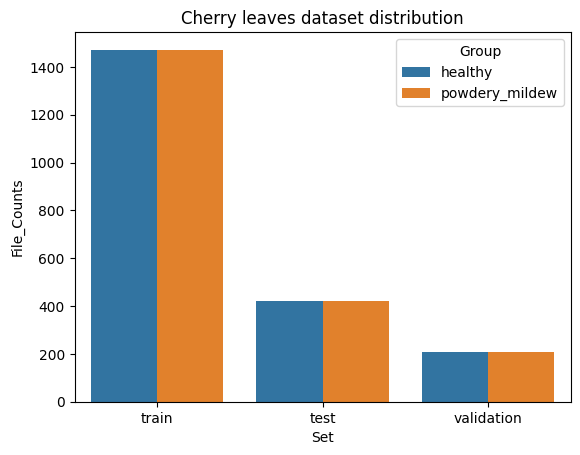

In [9]:
file_counts, data_split, group = [], [], []

for label in labels:
    for i in ['train', 'test', 'validation']:
        file_path = os.path.join(data_dir, i, label)
        files = os.listdir(file_path)
        num_files = len(files)
        file_counts.append(num_files)
        data_split.append(i)
        group.append(label)
        
        print(f'* {i} - {label}: {len(os.listdir(file_path))} images')

df = pd.DataFrame({'Set': data_split, 'Group': group, 'File_Counts': file_counts})

sns.barplot(data=df, x='Set', y='File_Counts', hue='Group')
plt.savefig(f'{output_dir}/labels_distribution.png',
            bbox_inches='tight', dpi=150)
plt.title('Cherry leaves dataset distribution')


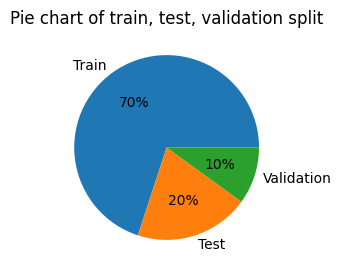

In [10]:
df_pie = df[0:3]
plt.figure(figsize=(3,3))
plt.pie(df_pie['File_Counts'], labels=['Train', 'Test', 'Validation'], autopct='%1.f%%')
plt.title('Pie chart of train, test, validation split')
plt.savefig(f'{output_dir}/set_distribution.png',
            bbox_inches='tight', dpi=150)
plt.show()

# Augment images

In [11]:
from tensorflow.keras.preprocessing.image import ImageDataGenerator

2023-08-06 12:22:12.563114: I tensorflow/tsl/cuda/cudart_stub.cc:28] Could not find cuda drivers on your machine, GPU will not be used.
2023-08-06 12:22:12.606583: I tensorflow/tsl/cuda/cudart_stub.cc:28] Could not find cuda drivers on your machine, GPU will not be used.
2023-08-06 12:22:12.607385: I tensorflow/core/platform/cpu_feature_guard.cc:182] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.
2023-08-06 12:22:13.545771: W tensorflow/compiler/tf2tensorrt/utils/py_utils.cc:38] TF-TRT Warning: Could not find TensorRT


In [12]:
augmented_img_data = ImageDataGenerator(rotation_range=20,
                                        width_shift_range=0.2,
                                        height_shift_range=0.2,
                                        shear_range=0.1,
                                        zoom_range=0.1,
                                        horizontal_flip=True,
                                        vertical_flip=True,
                                        fill_mode='nearest',
                                        rescale=1./255)

## Augment train set

In [13]:
batch_size = 32
train_set = augmented_img_data.flow_from_directory(train_dir,
                                                   target_size=image_shape[:2],
                                                   color_mode='rgb',
                                                   batch_size=batch_size,
                                                   class_mode='binary',
                                                   shuffle=True
                                                   )
train_set.class_indices

Found 2944 images belonging to 2 classes.


{'healthy': 0, 'powdery_mildew': 1}

# Augment validation set

In [14]:
val_set = ImageDataGenerator(rescale=1./255).flow_from_directory(val_dir,
                                                   target_size=image_shape[:2],
                                                   color_mode='rgb',
                                                   batch_size=batch_size,
                                                   class_mode='binary',
                                                   shuffle=False
                                                   )
val_set.class_indices

Found 420 images belonging to 2 classes.


{'healthy': 0, 'powdery_mildew': 1}

# Augment test set

In [15]:
test_set = ImageDataGenerator(rescale=1./255).flow_from_directory(test_dir,
                                                   target_size=image_shape[:2],
                                                   color_mode='rgb',
                                                   batch_size=batch_size,
                                                   class_mode='binary',
                                                   shuffle=False
                                                   )
test_set.class_indices

Found 844 images belonging to 2 classes.


{'healthy': 0, 'powdery_mildew': 1}

## Plot augmented train and validation images

(32, 256, 256, 3)


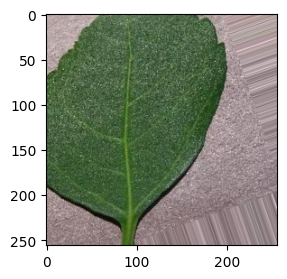

(32, 256, 256, 3)


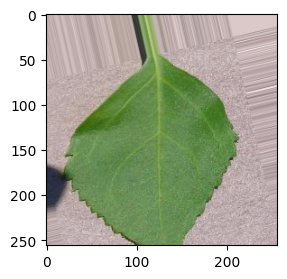

(32, 256, 256, 3)


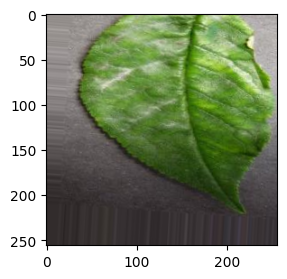

(32, 256, 256, 3)


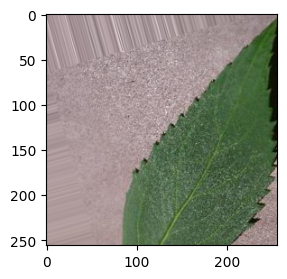

In [16]:
for i in range(4):
    plt.figure(figsize=(3,3))
    img, label = train_set.next()
    plt.imshow(img[i])
    print(img.shape)
    plt.show()


## Plot augmented validation images

(32, 256, 256, 3)


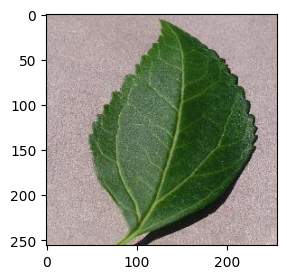

(32, 256, 256, 3)


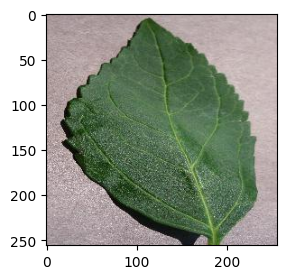

(32, 256, 256, 3)


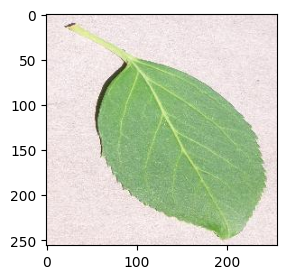

(32, 256, 256, 3)


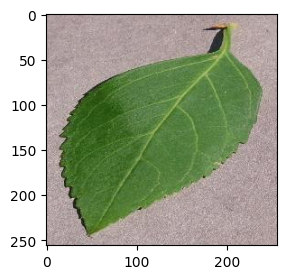

In [17]:
for i in range(4):
    plt.figure(figsize=(3,3))
    img, label = val_set.next()
    plt.imshow(img[i])
    print(img.shape)
    plt.show()

## Save class indices

In [18]:
joblib.dump(value=train_set.class_indices,
            filename=f"{output_dir}/class_indices.pkl")

['outputs/v1/class_indices.pkl']

## Build model

### Import required packages

In [19]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Activation, Dropout, Flatten, Dense, Conv2D, MaxPooling2D

### Model

In [20]:
import tensorflow as tf

def make_model():
    
    model = Sequential()

    # input layer  
    model.add(Conv2D(32, (3,3), activation='relu', input_shape=image_shape))
    model.add(MaxPooling2D(2,2))
    
    # hidden layers
    model.add(Conv2D(32, (3,3), activation='relu'))
    model.add(MaxPooling2D(2,2))
    
    model.add(Conv2D(64, (3,3), activation='relu'))
    model.add(MaxPooling2D(2,2))
    model.add(Dropout(0.25))

    model.add(Flatten()) # flattens array to 1D

    # fully connected layer
    model.add(Dense(64, activation='relu'))
    model.add(Dropout(0.5))

    # output
    model.add(Dense(1, activation='sigmoid'))

    model.compile(optimizer='adam', 
                  loss='binary_crossentropy',
                  metrics=['accuracy'])
    
    return model

In [21]:
make_model().summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 254, 254, 32)      896       
                                                                 
 max_pooling2d (MaxPooling2  (None, 127, 127, 32)      0         
 D)                                                              
                                                                 
 conv2d_1 (Conv2D)           (None, 125, 125, 32)      9248      
                                                                 
 max_pooling2d_1 (MaxPoolin  (None, 62, 62, 32)        0         
 g2D)                                                            
                                                                 
 conv2d_2 (Conv2D)           (None, 60, 60, 64)        18496     
                                                                 
 max_pooling2d_2 (MaxPoolin  (None, 30, 30, 64)        0

## Early stopping

In [22]:
from tensorflow.keras.callbacks import EarlyStopping

early_stop = EarlyStopping(monitor='val_loss', patience=3)

## Fit model for training

In [23]:
model = make_model()
model.fit(train_set,
          epochs=25,
          steps_per_epoch = len(train_set.classes) // batch_size,
          validation_data=val_set,
          callbacks=[early_stop],
          verbose=1
)

Epoch 1/25
92/92 [==============================] - 120s 1s/step - loss: 0.3853 - accuracy: 0.8084 - val_loss: 0.0851 - val_accuracy: 0.9881
Epoch 2/25
92/92 [==============================] - 102s 1s/step - loss: 0.0879 - accuracy: 0.9749 - val_loss: 0.0470 - val_accuracy: 0.9810
Epoch 3/25
92/92 [==============================] - 110s 1s/step - loss: 0.0741 - accuracy: 0.9759 - val_loss: 0.0078 - val_accuracy: 0.9976
Epoch 4/25
92/92 [==============================] - 104s 1s/step - loss: 0.0521 - accuracy: 0.9854 - val_loss: 0.0144 - val_accuracy: 0.9929
Epoch 5/25
92/92 [==============================] - 103s 1s/step - loss: 0.0491 - accuracy: 0.9861 - val_loss: 0.0269 - val_accuracy: 0.9881
Epoch 6/25
92/92 [==============================] - 118s 1s/step - loss: 0.0490 - accuracy: 0.9851 - val_loss: 0.0611 - val_accuracy: 0.9786


## Save model

In [24]:
model.save(f'{output_dir}/cherry_leaves_model.h5')

/workspace/.pyenv_mirror/user/current/lib/python3.11/site-packages/keras/src/engine/training.py:3000: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


## Evaluating model performance

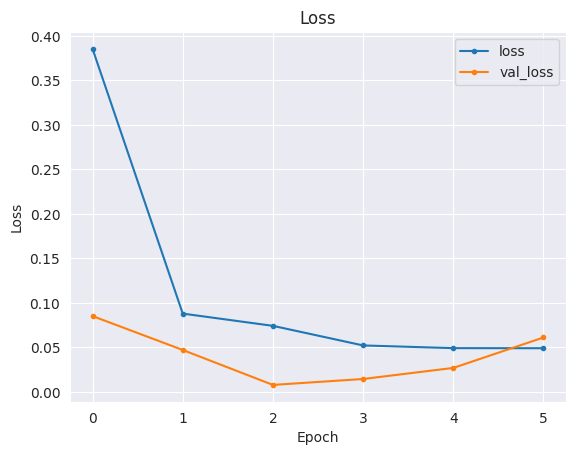

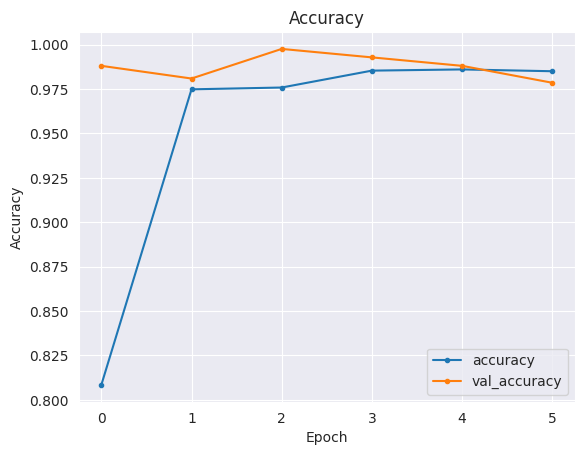

In [25]:
losses = pd.DataFrame(model.history.history)

sns.set_style('darkgrid')
losses[['loss', 'val_loss']].plot(style='.-')
plt.title('Loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.savefig(f'{output_dir}/model_training_loss.png',
            bbox_inches='tight', dpi=150)
plt.show()

print('\n')
losses[['accuracy', 'val_accuracy']].plot(style='.-')
plt.title('Accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.savefig(f'{output_dir}/model_training_acc.png',
            bbox_inches='tight', dpi=150)
plt.show()

## Model evaluation

In [26]:
from keras.models import load_model
model = load_model(f'outputs/{version_num}/cherry_leaves_model.h5')

In [27]:
evaluation = model.evaluate(test_set)
print(f'Test set evaluation reports an accuracy of {evaluation[1]} and a loss of {evaluation[0]}')

27/27 [==============================] - 7s 250ms/step - loss: 0.0754 - accuracy: 0.9763
Test set evaluation reports an accuracy of 0.9763033390045166 and a loss of 0.07544465363025665


### Save evaluation pickle

In [28]:
joblib.dump(value=evaluation,
            filename=f"outputs/v1/evaluation.pkl")

['outputs/v1/evaluation.pkl']

## Test on unseen data

1/1 [==============================] - 0s 93ms/step
Prediction is: powdery_mildew
Prediction probability is: 98.25382232666016%
Image shape is: (256, 256, 3)


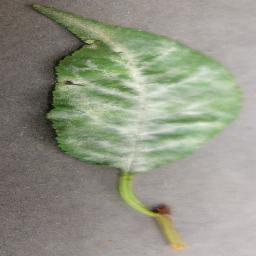

In [29]:
from tensorflow.keras.preprocessing import image

point = 80 # points at specified file index
label = labels[1] # pick 0 for healthy and 1 for powdery_mildew

img = image.load_img(test_dir + '/'+ label + '/'+ os.listdir(test_dir +'/'+ label)[point])
img_arr = np.array(img)/255.0
pred_proba = model.predict(np.expand_dims(img_arr, axis=0))

predicted_class = 1 if pred_proba[0,0] > 0.5 else 0

predicted_label = labels[predicted_class]

if predicted_class == 0:
    predicted_prob = 1 - pred_proba[0,0]
else:
    predicted_prob = pred_proba[0,0]

print("Prediction is:", predicted_label)
print(f"Prediction probability is: {predicted_prob*100}%")
print("Image shape is:", img_arr.shape)
img

## Confusion matrix

In [30]:
label_arr = []

for label in labels:
    files_folder = test_dir + '/' + label
    file_list = os.listdir(files_folder)
    
    for file in file_list:
         file_path = os.path.join(files_folder, file)
         label_arr.append(label)

binary_labels = [0 if item == 'healthy' else 1 for item in label_arr]
print(len(binary_labels))

844


In [31]:
from sklearn.metrics import accuracy_score, confusion_matrix

predictions = model.predict(test_set)
predicted_labels = (predictions > 0.5).astype(int)

test_accuracy = accuracy_score(binary_labels, predicted_labels)
print("Test Accuracy:", test_accuracy)

27/27 [==============================] - 7s 246ms/step
Test Accuracy: 0.976303317535545


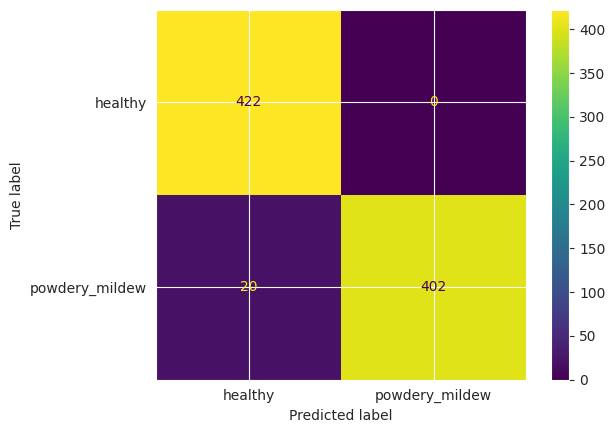

In [32]:
from sklearn import metrics

actual = binary_labels
pred = predicted_labels
predicted = [label[0] for label in pred] # convert predicted to same format as actual label list

cf_matrix = metrics.confusion_matrix(actual, predicted)

cm_display = metrics.ConfusionMatrixDisplay(confusion_matrix=cf_matrix, 
                                            display_labels=[labels[0], labels[1]])

cm_display.plot()
plt.savefig(f'{output_dir}/conf_matrix.png',
            bbox_inches='tight', dpi=150)
plt.show()

## Metrics table

In [33]:
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, confusion_matrix

# calculate specificity 
TN = cf_matrix[0,0]
FP = cf_matrix[0,1]
specificty = TN / (TN + FP)

# calculate accuracy, precision, recall and F1 score
accuracy = accuracy_score(actual, predicted)
precision = precision_score(actual, predicted)
recall = recall_score(actual, predicted)
f1 = f1_score(actual, predicted)

# create summary table
summary_df = pd.DataFrame([{"Accuracy:": accuracy,
                            "Precision:": precision,
                            "Specificity:": specificty,
                            "Recall:": recall,
                            "F1-score:": f1}])

summary_df.index = ['Cherry leaves model']
summary_df

,Accuracy:,Precision:,Specificity:,Recall:,F1-score:
Cherry leaves model,0.976303,1.0,1.0,0.952607,0.975728


## ROC plot

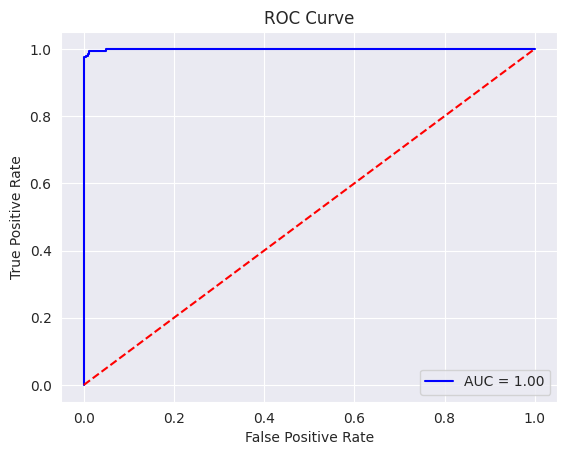

In [34]:
from sklearn.metrics import roc_curve, roc_auc_score

fpr, tpr, _ = roc_curve(actual, predictions)
roc_auc = roc_auc_score(actual, predictions)

plt.plot(fpr, tpr, color='blue', label=f'AUC = {roc_auc:.2f}')
plt.plot([0,1], [0,1], color='red', linestyle='--')
plt.ylabel('True Positive Rate')
plt.xlabel('False Positive Rate')
plt.title('ROC Curve')
plt.legend(loc='best')
plt.savefig(f'{output_dir}/roc_plot.png',
            bbox_inches='tight', dpi=150)
plt.show()

## Precision recall plot

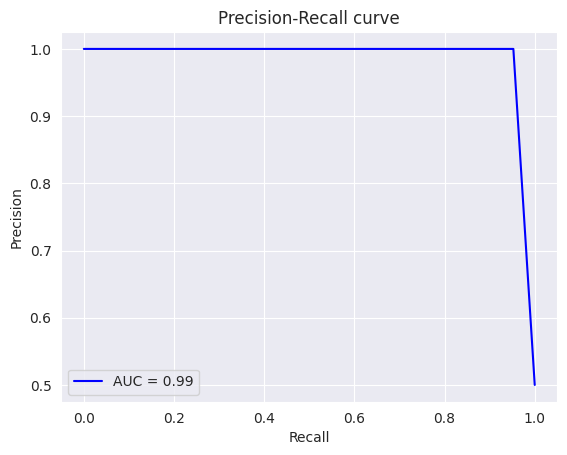

In [35]:
from sklearn.metrics import precision_recall_curve, average_precision_score
from sklearn.metrics import auc

prec, recall, _ = precision_recall_curve(actual, predicted)
area_under_curve = auc(recall, prec)

plt.plot(recall, prec, color='blue', label=f'AUC = {area_under_curve:.2f}')
plt.xlabel('Recall')
plt.ylabel('Precision')
plt.title('Precision-Recall curve')
plt.legend(loc='best')
plt.savefig(f'{output_dir}/precision_recall_plot.png',
            bbox_inches='tight', dpi=150)
plt.show()